In [6]:
import os
from typing import Annotated

from typing_extensions import TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langsmith import utils 

# 환경 변수 로드
load_dotenv()

utils.tracing_is_enabled()

True

# Build a Basic Chatbot

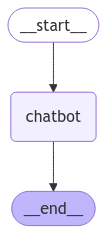

In [2]:


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

# 엔트리 포인트 설정, 그래프가 실행될 때 어디서부터 시작할지 정의하는 역할할
graph_builder.add_edge(START, "chatbot")

# 피니쉬 포인트 설정, 그래프가 종료될 때 어디서 끝낼지 정의하는 역할
graph_builder.add_edge("chatbot", END)

# compilie 메서드 호출로 그래프를 컴파일 -> CompliledGraph 객체가 생성됨
# CompliledGraph 객를 이용하면, 우리가 만든 상태(State) 그래프를 실행(invoke)할 수 있음
graph = graph_builder.compile()


try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [3]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break
    finally:
        print(" **** 1 cycle done ****")

Assistant: Hello! How can I help you today? If you have any questions or need assistance with English, I'm here to help. Just let me know what you need.
 **** 1 cycle done ****
Goodbye!
 **** 1 cycle done ****


# Enhancing the Chatbot with Tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
# Tavily 검색 엔진을 사용 
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as:.'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step . You define nodes to perform'}]

In [37]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [38]:
# State는 전체 애플리케이션의 현재 상태를 나타내는 공유 데이터 구조
# 전체 워크플로우의 컨텍스트 유지; 노드 간 정보 공유; TypedDict 또는 Pydantic BaseModel로 정의 

# 모든 정보 실시간 업데이트, 그래프 내에서 이 상태가 모든 직원(Agent)에게 공유 가능
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [39]:
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# LLM에 bind_tools 기능을 추가
# bind_tools를 추가하면 LLM이 검색 엔진을 사용할 때 올바른 JSON 형식을 따르도록 알려줌
# 즉, LLM이 검색 엔진과 올바르게 상호작용할 수 있도록 설정하는 과정
llm_with_tools = llm.bind_tools(tools)

In [40]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## BasicToolNode 구현
역할
- 현재 상태의 가장 최근 메시지 확인
- 메시지에 tool_calls 정보가 포함되어 있다면, 도구 실행
- 이 과정에서 llm의 tool_calling 기능 활용

## Tool_calling
- 최신 LLM은 외부 도구를 자동으로 호출하는 기능을 지원
- 즉, 챗봇이 직접 웹 검색, 계산기, API 호출 등 다양한 도구를 필요에 따라 실행

## BasicToolNode - > ToolNode
- 지금은 직접 BasicToolNode를 구현하여 원리를 이해하지만, 나중에는 랭그래프의 ToolNode를 사용 

In [41]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}



In [42]:

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 도구 노드가 추가되면, 조건부 엣지(Conditional Edges)를 정의해야 함
- 엣지(edges) : 그래프의 노드 간의 흐름제어 하는 역할
- 조건부 엣지는 if 문을 포함하여 특정 조건에 따라 다른 노드로 이동할 수 있도록 함 

## 조건부 엣지 역할
- 현재 그래프 상태(graph state) 받아옴
- 어떤 노드로 이동할지 결정하는 라우팅함수 실행
- 라우팅 함수는 문자열 또는 문자열 리스트 반환, 이는 다으멩 실행할 노드의 이름을 나타냄 

In [43]:
# 챗봇의 응답 확인하고, tool_calls 포함되어 있는지 확인
# tool_calls가 포함되어 있으면 tools로 라우팅, 그렇지 않으면 END로 라우팅 

# 직접 route_tools를 구현하여 원리를 이해
# 나중에는 langgraph의 tools_condition을 사용하여 더 간단하게 구현 가능 
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# `tools_condition` 함수는 챗봇이 도구를 사용해야 한다고 판단하면 "tools"를 반환하고,  
# 직접 응답해도 괜찮다면 "END"를 반환 
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # 아래 딕셔너리를 사용하면 그래프가 조건의 출력을 특정 노드로 해석하도록 설정
    # 기본값은 identity function(입력을 그대로 반환)이며,  
    # 만약 "tools"라는 노드 대신 다른 노드 이름을 사용하고 싶다면,  
    # 예를 들어 "tools": "my_tools"로 변경할 수 있음 
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

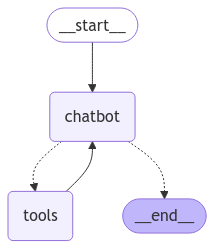

In [44]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [46]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://blog.naver.com/wild_it/223268788749", "content": "\uc708\ub3c4\uc6b0 11\uc5d0 \uc544\uc774\ud3f0\uc744 \uc5f0\uacb0\ud558\uae30 \uc704\ud574\uc11c\ub294 \ubcc4\ub3c4 \ud504\ub85c\uadf8\ub7a8\uc744 \ub2e4\uc6b4\ub85c\ub4dc\ud560 \ud544\uc694\uac00 \uc5c6\uc2b5\ub2c8\ub2e4. \u200b. \uba3c\uc800 \uc5f0\uacb0\uc5d0 \ud544\uc694\ud55c \ud504\ub85c\uadf8\ub7a8\uc744 \uc2e4\ud589\uc2dc\ucf1c\ubcf4\uaca0\uc2b5\ub2c8\ub2e4. \ud558\ub2e8"}, {"url": "https://blog.naver.com/culture-box/223551367798", "content": "\uc6b0\ub9ac\uac00 \uc138\uc6b4 \uacc4\ud68d\uc740 \uc5b4\ub5bb\uac8c \ub3fc? \u200b. The internet's gone wild watching movie stars on trial. \ub514 \uc778\ud130\ub137\uc2a4 \uac74 \uc640\uc77c\ub4dc \uc6cc\uce58\uc789 \ubb34\ube44 \uc2a4\ud0c0\uc988 \uc628 \ud2b8\ub77c\uc774\uc5bc."}]
Assistant: 네이버 블로거 "와일딧"은 "[https://blog.naver.com/wild\_it/223268788749](https://blog.naver.com/wild_it/223268788749)"와 "[https://blog.naver.com/culture-box/22355136